# Evaluate MPAS and FV3 ensembles
- compare severe weather surrogates and SPC storm reports
- May 2023 and 2024 Hazardous Weather Testbeds

### Import modules
- [contingency_table.py](contingency_table.py) and [hwt.py](hwt.py) are custom modules
- put in current directory

In [8]:
import logging
import os
import pdb
from functools import lru_cache, partial
from multiprocessing import Pool
from pathlib import Path

import cartopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray

# First put contingency_table.py and hwt.py in current directory.
from contingency_table import accuracy, bias, csi, ets, far, hk, hss, pod, pofd, total
from hwt import (
    Model,
    extent,
    firstRun,
    fv3,
    helicityThresholds,
    mpas,
    projection,
    windThresholds,
)
from scipy.ndimage import gaussian_filter, maximum_filter

sns.set_theme()  # nice background on plots
logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)
tmpdir = Path(os.getenv("TMPDIR"))

### Define `group`, `thresholds`, `genericnames`, `models`, `conus_mask`, and `datadir`

In [9]:
group = "uh"
thresholds = helicityThresholds if group == "uh" else windThresholds
genericnames = (
    ["0-1km UH", "0-3km UH", "2-5km UH"] if group == "uh" else ["updraft max", "10m speed max"]
)

models = [fv3, mpas]

for model in models:
    model.group = group

# assert models all have same number of variables
nvars = len(genericnames)
assert all(
    [len(model.v) == nvars for model in models]
), "Models have different number of variables to analyze"

conus_mask = xarray.open_dataarray(
    Path(os.getenv("HOME").replace(os.getenv("USER"), "ahijevyc")) / "HWT_2024.conus.nc"
)

# Replace USER with "ahijevyc". So it points to his TMPDIR, not others'.
datadir = Path(str(tmpdir).replace(os.getenv("USER"), "ahijevyc"))
print(datadir)

/glade/derecho/scratch/ahijevyc/tmp


### Illustrate filter that will be applied to forecast

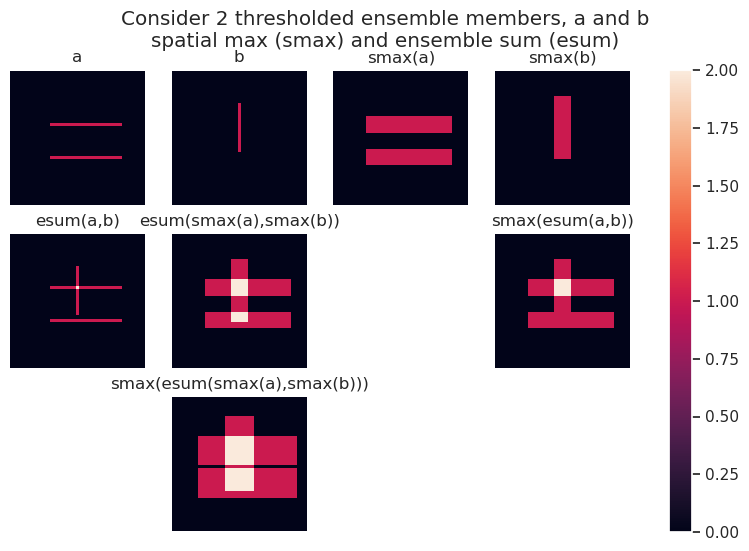

In [10]:
filter_size1 = (
    25  # max-filter size before summing ensemble members. already applied in make_fy_fo.ipynb
)
filter_size2 = 13  # apply another filter here.

a = np.zeros((41, 41))  # all zero, square matrix
b = np.zeros((41, 41))  # all zero, square matrix
a[16, 12:34] = 1  # except two points are equal to one
a[26, 12:34] = 1  # except two points are equal to one
b[10:25, 20] = 1


def smax(x, filter_size=5):
    return maximum_filter(x, size=filter_size)


fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(10, 6))

fig.suptitle(
    "Consider 2 thresholded ensemble members, a and b"
    "\nspatial max (smax) and ensemble sum (esum)"
)
vmax = 2
axes[0, 0].imshow(a, interpolation="nearest", vmax=vmax)
axes[0, 0].set_title("a")
axes[0, 1].imshow(b, interpolation="nearest", vmax=vmax)
axes[0, 1].set_title("b")
axes[0, 2].imshow(smax(a), interpolation="nearest", vmax=vmax)
axes[0, 2].set_title("smax(a)")
_ = axes[0, 3].imshow(smax(b), interpolation="nearest", vmax=vmax)
axes[0, 3].set_title("smax(b)")
fig.colorbar(_, ax=axes)
_ = [ax.set_axis_off() for ax in axes.flat]
fig.savefig(tmpdir / "row0.png")

axes[1, 0].imshow(a + b, vmax=vmax)
axes[1, 0].set_title("esum(a,b)")
axes[1, 1].imshow(smax(a) + smax(b), interpolation="nearest", vmax=vmax)
axes[1, 1].set_title("esum(smax(a),smax(b))")
axes[1, 3].imshow(smax(a + b), interpolation="nearest", vmax=vmax)
axes[1, 3].set_title("smax(esum(a,b))")
fig.savefig(tmpdir / "row1.png")

axes[2, 1].imshow(smax(smax(a) + smax(b)), interpolation="nearest", vmax=vmax)
axes[2, 1].set_title("smax(esum(smax(a),smax(b)))")
fig.savefig(tmpdir / "row2.png")

In [11]:
thresholds

<xarray.DataArray (thresh: 12)> Size: 96B
array([ 10,  20,  30,  40,  50,  75, 100, 125, 150, 200, 250, 300])
Dimensions without coordinates: thresh
Attributes:
    units:       $m^2/s^2$
    short_name:  uh

In [12]:
@lru_cache(maxsize=2, typed=False)
def get_obs(datadir: Path, valid_date: pd.Timestamp) -> xarray.DataArray:
    """
    Get observation DataArray.
    Mask it with CONUS.
    """
    rptfile = datadir / f"near_rpt.{valid_date.strftime('%Y-%m-%d %H:%M:%S')}.nc"
    logging.info(f"open existing {rptfile}")
    obs = xarray.open_dataarray(rptfile)
    logging.info(f"opened existing {rptfile}")
    any = obs.max(dim="rpt_type").assign_coords(rpt_type="any")
    obs = xarray.concat([obs, any], dim="rpt_type")

    # Keep obs where conus_mask is True; otherwise set to nan.
    # nans will propagate to h, m, f, and n and not be counted when the .sum() function
    # is used below.
    obs = obs.where(conus_mask)
    obs.name = "obs"
    del obs.attrs["units"]
    del obs.attrs["long_name"]
    obs["valid_date"] = valid_date

    return obs


def get_fcst(
    datadir: Path,
    model: Model,
    group: str,
    valid_date: pd.Timestamp,
    filter_size=None,
    filter_type="maximum",
) -> xarray.DataArray:
    """
    Get forecast DataArray. Smooth it.
    Encode source filename.
    Assert no missing data.
    Don't mask it like get_obs() does. We mask after spatial filtering.
    """

    logging.info(f"size-{filter_size1} max filter")
    ncfile = datadir / (
        f"forecast_yes.{model}.{group}.{filter_size1}.{valid_date.strftime('%Y%m%d')}.nc"
    )
    logging.info(f"open existing {ncfile}")
    fcst = xarray.open_dataarray(ncfile)
    fcst.encoding["source"] = ncfile
    # Assign generic variable names instead of model-dependent names.
    fcst = fcst.assign_coords({"variable": genericnames})
    assert not fcst.isnull().any(), f"{fcst.isnull().sum()} null in {fcst.name}"
    assert fcst.min() >= 0, f"{ncfile} min < 0 {fcst.min()}"
    # Tried DataArray.equal but thresholds has dimension w/o coordinates
    assert all(fcst.thresh == thresholds), f"{fcst.thresh} != {thresholds}"

    if filter_size is not None:
        londim = fcst.dims.index("lon")
        latdim = fcst.dims.index("lat")
        logging.info(f"size-{filter_size2} filter")
        if filter_type == "maximum":
            fcst.values = maximum_filter(fcst.values, size=filter_size2, axes=(londim, latdim))
        if filter_type == "gaussian":
            fcst.values = gaussian_filter(
                fcst.values, sigma=filter_size2, axes=(londim, latdim)
            )
        fcst.attrs["filter_size"] = filter_size2
        fcst.attrs["filter_type"] = filter_type
    fcst["valid_date"] = valid_date

    # Divide fcst # members over threshold by # members to get probability.
    fcst = fcst / fcst.attrs["nmem"]
    fcst.name = "fcst"
    fcst.attrs["long_name"] = "probability"

    return fcst


def scalarL1L2Norms(fcst: xarray.DataArray, obs: xarray.DataArray) -> xarray.Dataset:
    # scalarL1L2 named like in Meteorological Evaluation Tools (MET)

    fcstObs = fcst * obs
    fcstObs.name = fcst.name + obs.name
    fcstFcst = fcst**2
    fcstFcst.name = fcst.name + fcst.name
    obsObs = obs**2
    obsObs.name = obs.name + obs.name

    ds = xarray.merge([fcst, obs, fcstObs, fcstFcst, obsObs])
    return ds

In [13]:
def get_hmfn(valid_date: pd.Timestamp, model: Model | xarray.DataArray):
    """
    Match forecast and observations
    for one valid date and model.
    If model is a DataArray assume climatology

    Calculate hits, misses, false alarms, and correct nulls.

    Call scalarL1L2Norms with fcst and obs.
    Return contingency table (hmfn) and L1 and L2 norms.
    """

    if type(model) == xarray.DataArray:
        fcst = model
        model = "climo"
    else:
        fcst = get_fcst(datadir, model, group, valid_date, filter_size=filter_size2)
    logging.info("made fcst")

    # Define observations
    obs = get_obs(datadir, valid_date)

    # Use == 1 and == 0 to avoid masked points. You can't use ~fcst because you can't negate a masked point.
    # fcst > 0 so fcst is a yes forecast if ANY of the members are yes.
    h = (fcst > 0) * (obs == 1)
    m = (fcst == 0) * (obs == 1)
    f = (fcst > 0) * (obs == 0)
    n = (fcst == 0) * (obs == 0)
    counts = ["hits", "misses", "false alarms", "correct nulls"]
    hmfn = (
        xarray.concat([h, m, f, n], dim="count")
        .sum(dim=["lon", "lat"])
        .assign_coords(count=counts, valid_date=valid_date, model=str(model))
        .expand_dims(["valid_date", "model"])
    )

    hmfn.name = "hmfn" # DataArray to hold contingency table counts
    hmfn.attrs = fcst.attrs
    logging.info("made hmfn")

    # mask conus or else sum of forecasts will have ocean too. Can't use ~fcst however.
    fcst = fcst.where(conus_mask)

    sl1l2 = scalarL1L2Norms(fcst, obs)

    sl1l2 = (
        sl1l2.sum(dim=["lon", "lat"])
        .assign_coords(valid_date=valid_date)
        .expand_dims("valid_date")
    )
    if model != "climo":
        sl1l2 = sl1l2.assign_coords(model=str(model)).expand_dims("model")

    sl1l2.attrs = fcst.attrs
    print(f"{valid_date} {model}", end=" ")

    return xarray.merge([hmfn, sl1l2])

# Use climatological frequency of "torn" "wind" "hail" "all" as reference forecast
# when calculating Skill Score. This must be calculated beforehand
# to define it statically like this. See how this is done below.
rpt_types = ["torn", "wind", "hail", "any"]
climo = xarray.DataArray(
    [0.003963, 0.01895, 0.01454, 0.02948], coords={"rpt_type": rpt_types}, name="fcst"
)

## Get contingency table and Brier Score for all valid dates.
- First time this is executed, calculate the table and Brier Score for each date
    - This takes hours unless multiprocessing is used.
    - Process multiple valid dates in parallel.
    - Reserve enough memory beforehand--more jobs in parallel require more memory.
    - Save data to disk.
- Subsequent times, it will read the data from disk.

In [14]:
sfx = (
    f".2023-2024.{group}{len(genericnames)}.{len(thresholds)}.{filter_size1},{filter_size2}.nc"
)
d2023 = pd.date_range(start=firstRun(2023), end="20230531", freq="1D")
d2024 = pd.date_range(start=firstRun(2024), end="20240531", freq="1D")
valid_dates = d2023.union(d2024)

processes = 1
# list of (date, model) tuples for multiprocessing pool.
joblist = [(valid_date, model) for valid_date in valid_dates for model in models]

# Call multiprocessing and return a Dataset 2 times for hmfn, hmfnref.
# If you call multiprocessing and make all datasets, you use mucho memory.

# Contingency table counts (hits, misses, false alarms, nulls), and partial sums.
ofile = datadir / f"hmfn{sfx}"
if not os.path.exists(ofile):
    logging.warning(f"make {ofile}")
    if processes > 1:
        with Pool(processes=processes) as pool:
            hmfn = pool.starmap(
                get_hmfn,
                joblist,
            )
    else:
        hmfn = [get_hmfn(*job) for job in joblist]

    hmfn = xarray.combine_by_coords(
        hmfn,
        combine_attrs="drop_conflicts",
    )
    hmfn.to_netcdf(ofile)
    logging.warning(ofile)
logging.warning(f"open {ofile}")
hmfn = xarray.open_dataset(ofile)

# fcst = climo
ofile2 = datadir / "hmfnref.2023-2024.nc"
if os.path.exists(ofile2):
    logging.warning(f"open {ofile2}")
    hmfnref = xarray.open_dataset(ofile2)
else:
    logging.warning(f"make {ofile2}")
    if processes > 1:
        with Pool(processes=processes) as pool:
            hmfnref = pool.starmap(
                get_hmfn,
                [(valid_date, climo) for valid_date in valid_dates],
            )
    else:
        hmfnref = [get_hmfn(valid_date, climo) for valid_date in valid_dates]

    hmfnref = xarray.combine_by_coords(
        hmfnref,
        combine_attrs="drop_conflicts",
    )
    hmfnref.to_netcdf(ofile2)
    logging.warning(ofile2)

2024-10-30 10:29:04,027 open /glade/derecho/scratch/ahijevyc/tmp/hmfn.2023-2024.uh3.12.25,13.nc
2024-10-30 10:29:04,044 open /glade/derecho/scratch/ahijevyc/tmp/hmfnref.2023-2024.nc


## Plot results
For example, equitable threat score (ets), bias, Heidke Skill Score (hss), false alarm ratio

- Equitable Threat Score is proportion hits (CSI) w/o chance
- Heidke Skill Score is proportion hits & correct nulls (accuracy) w/o chance
  
### Ways to stratify results
- model
- dayForecast
- valid_date
- threshold
- variable
- rpt_type

2024-10-30 10:29:10,628 /glade/derecho/scratch/ahijevyc/tmp/ets.2023-2024.uh3.12.25,13.png


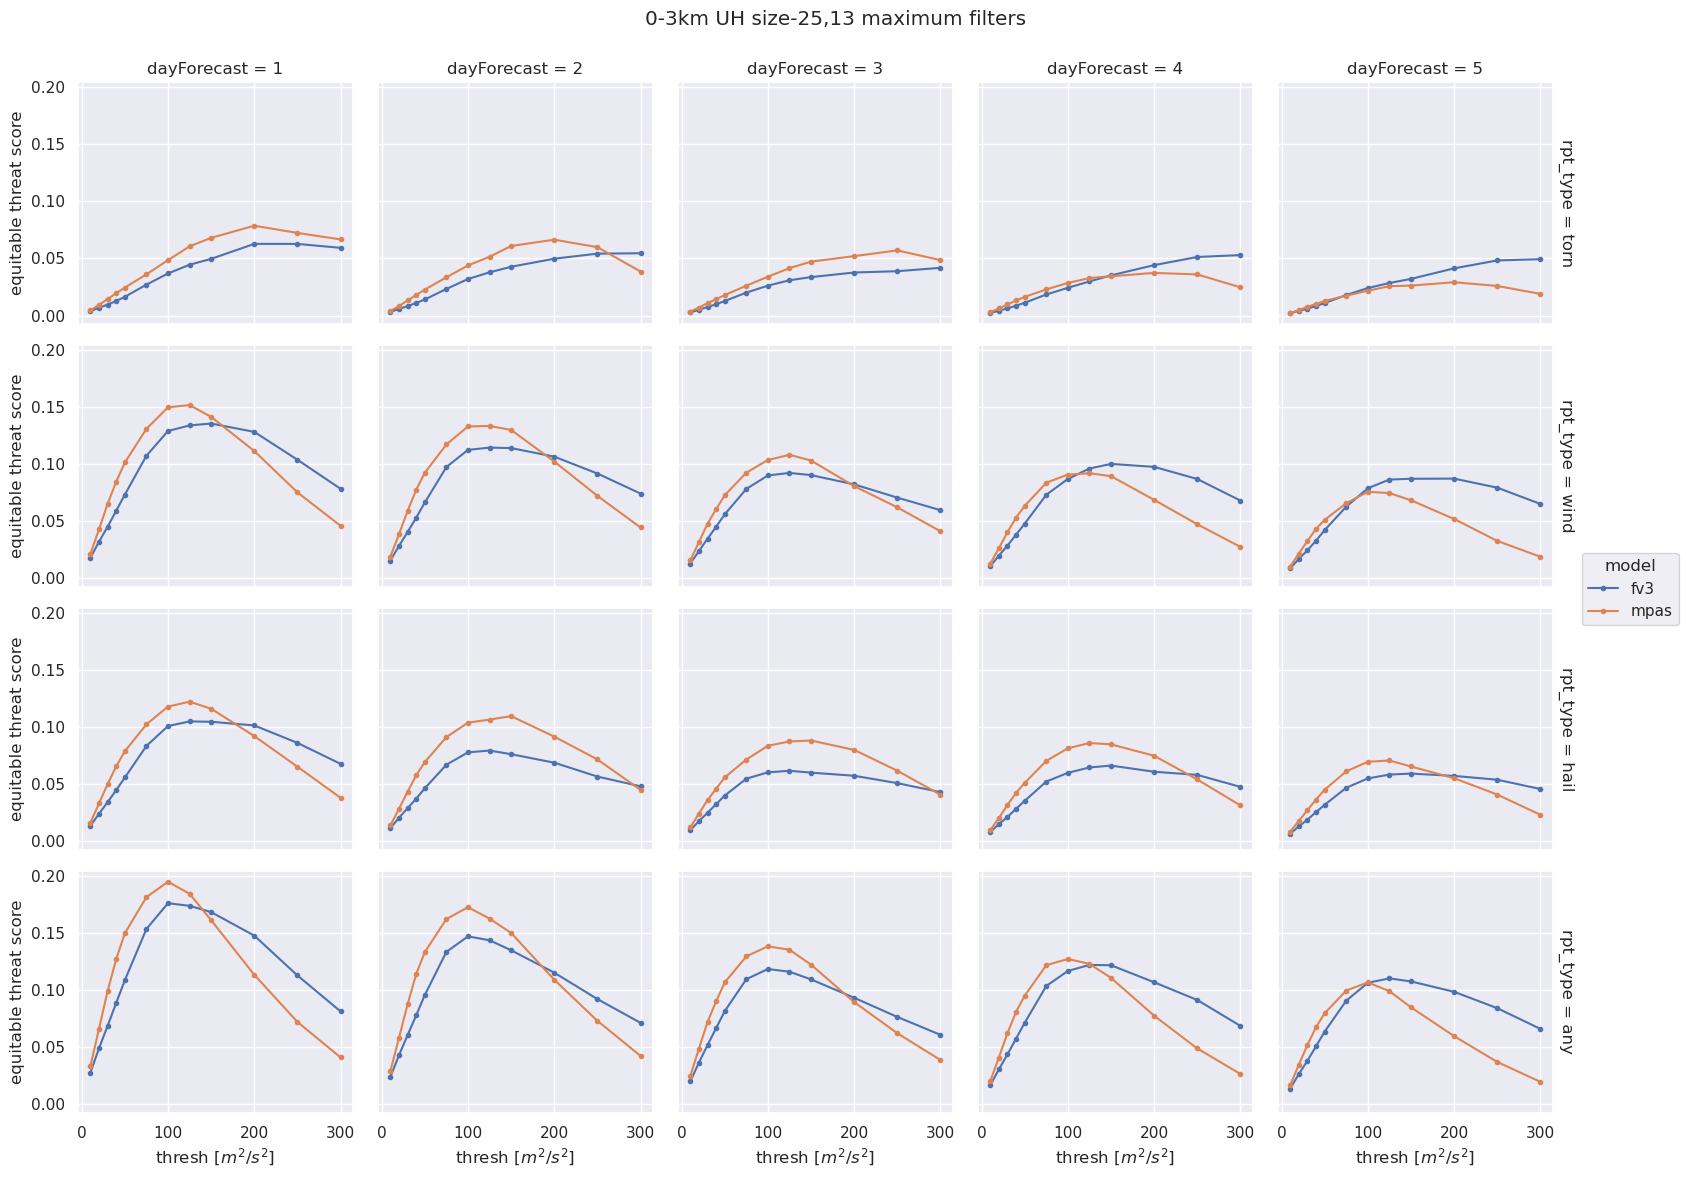

In [15]:
variable = genericnames[1]
s = hmfn.hmfn
# s = s.where(s.valid_date > pd.to_datetime("20240101")) # just one year
s = s.sel(dayForecast=slice(1, 5))  # just dayForecast 1-5
s = s.mean(dim="valid_date")
s = s.sel(variable=variable)
s = ets(s)
g = s.plot(col="dayForecast", row="rpt_type", hue="model", marker=".")
g.fig.suptitle(f"{variable} size-{filter_size1},{filter_size2} maximum filters")
ofile = tmpdir / f"{s.attrs['short_name']}{sfx.rstrip('.nc')}.png"
g.fig.subplots_adjust(top=0.92)
g.fig.savefig(ofile, dpi=150)
logging.warning(ofile)

/glade/derecho/scratch/ahijevyc/tmp/ets.2023-2024.uh3.12.25,13.torn.png


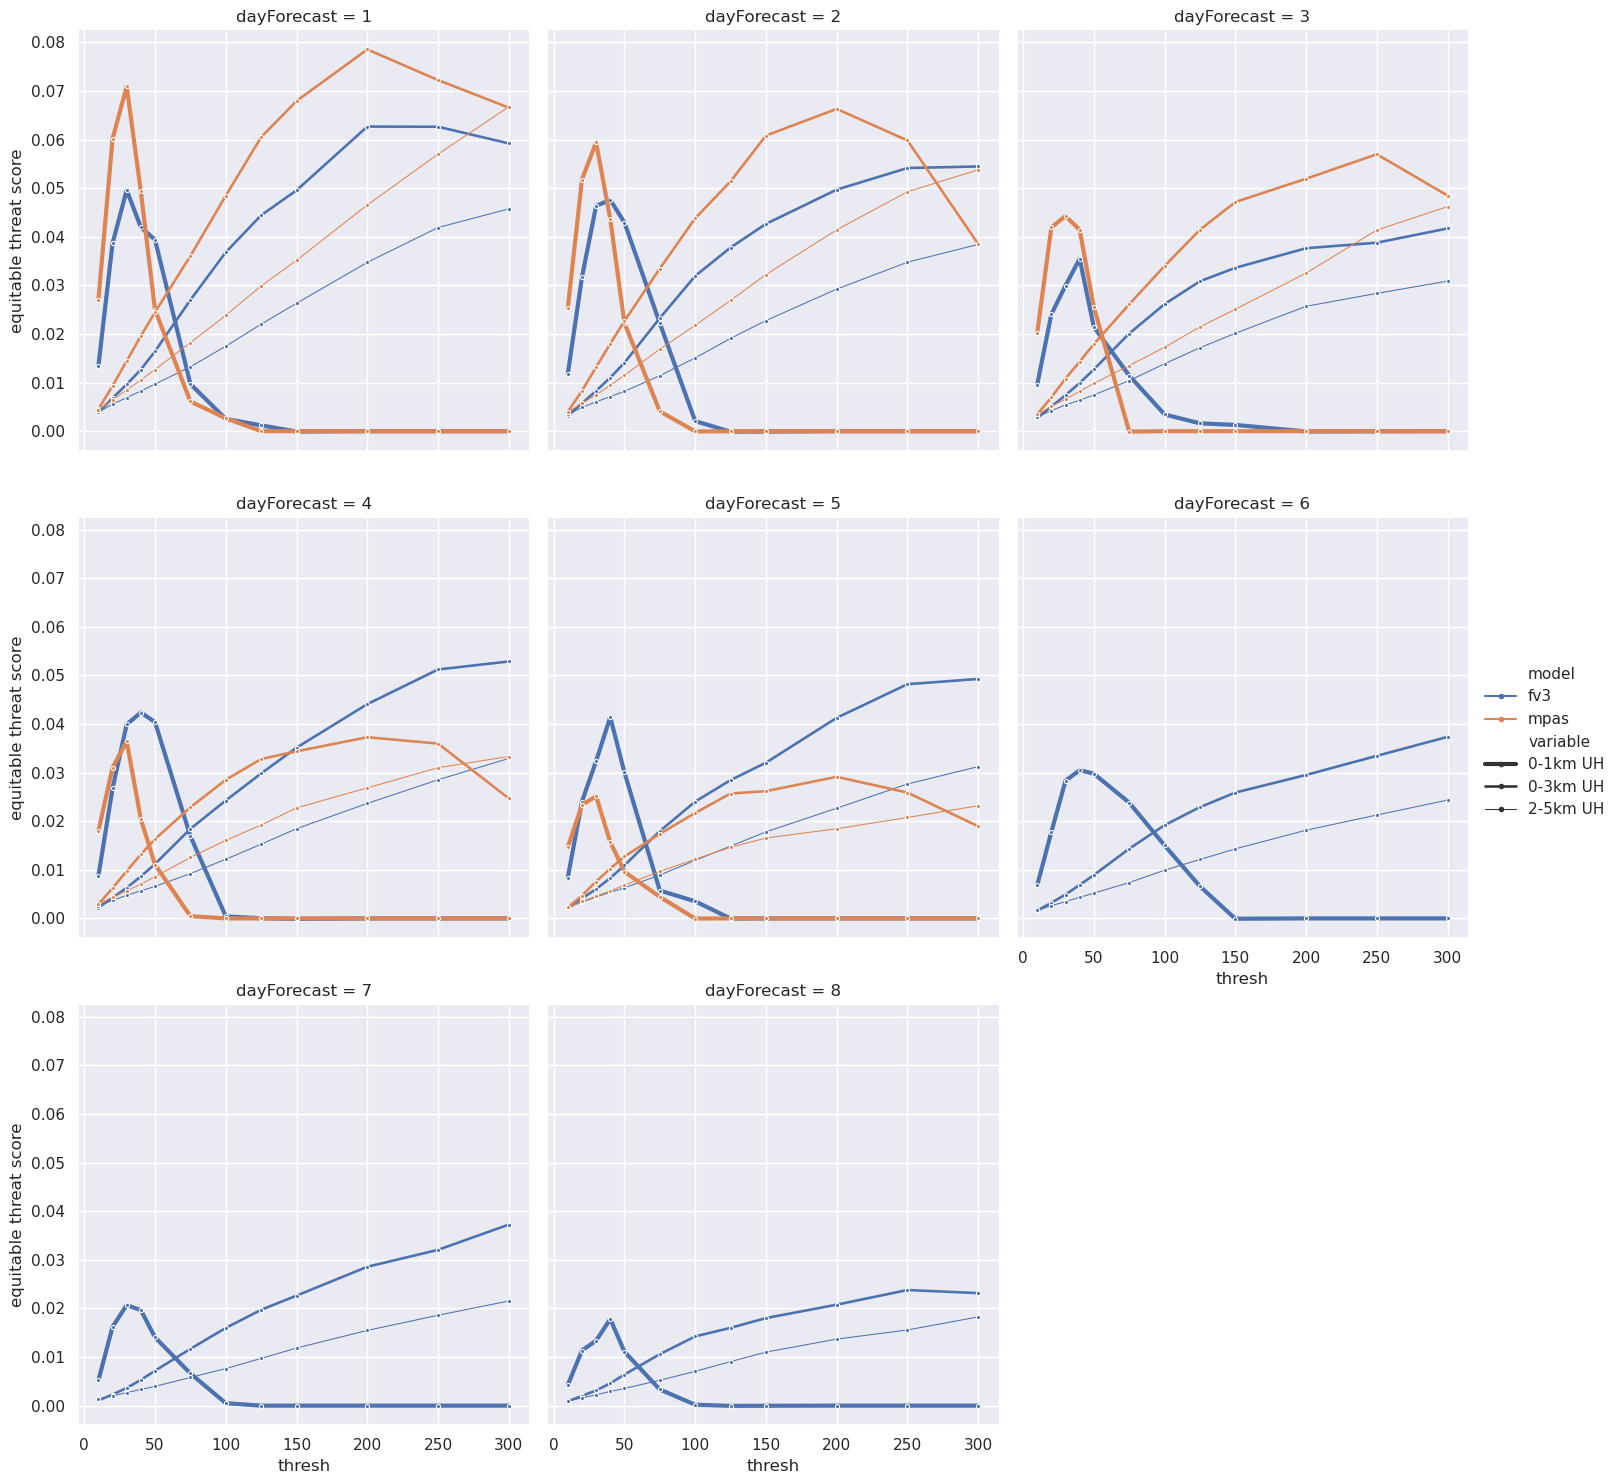

In [16]:
rpt_type = "torn"
s = hmfn.hmfn
s = ets(s.sum(dim="valid_date"))
g = sns.relplot(
    data=s.sel(rpt_type=rpt_type).to_dataframe().reset_index(),
    col="dayForecast",
    col_wrap=3,
    y="equitable threat score",
    x="thresh",
    kind="line",
    hue="model",
    size="variable",
    marker=".",
)
ofile = tmpdir / f"{s.attrs['short_name']}{sfx.rstrip('.nc')}.{rpt_type}.png"
g.savefig(ofile)
print(ofile)

/glade/derecho/scratch/ahijevyc/tmp/ets.2023-2024.uh3.12.25,13.3.fv3.0-3km UH.torn.png


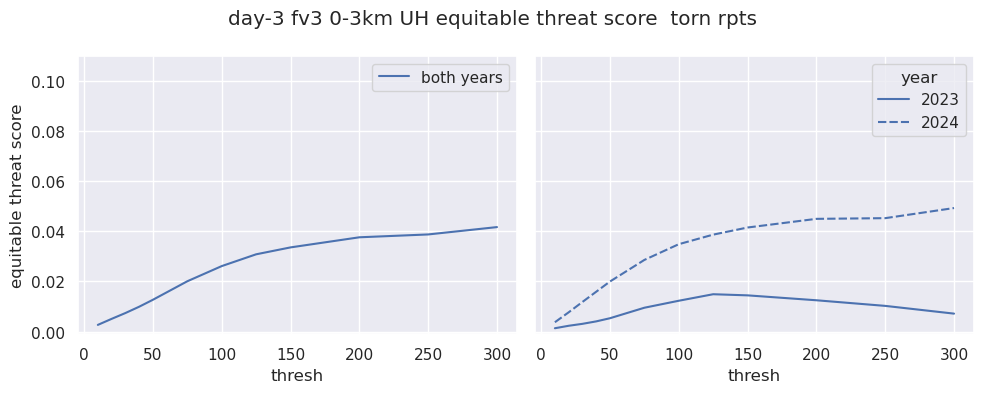

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
s = ets(hmfn.hmfn.sum(dim="valid_date"))
sel = dict(
    dayForecast=3,
    model="fv3",
    rpt_type=rpt_type,
    variable=variable,
)
y = "equitable threat score"
g = sns.lineplot(
    s.sel(sel).to_dataframe().reset_index(),
    ax=axes[0],
    y=y,
    x="thresh",
    legend=True,
    label="both years",
)
s = hmfn.hmfn
s["year"] = s["valid_date"].dt.year
s = ets(s.groupby("year").sum(dim="valid_date"))
g = sns.lineplot(
    ax=axes[1],
    data=s.sel(sel).to_dataframe().reset_index(),
    y=y,
    x="thresh",
    style="year",
)
ofile = (
    tmpdir
    / f"{s.attrs['short_name']}{sfx.rstrip('.nc')}.{sel['dayForecast']}.{sel['model']}.{sel['variable']}.{rpt_type}.png"
)
for ax in axes.ravel():
    # axes limits, labels
    ax.set_ylim(top=0.11)

plt.suptitle(f"day-{sel['dayForecast']} {sel['model']} {sel['variable']} {y}  {rpt_type} rpts")
plt.tight_layout()
fig.savefig(ofile)
print(ofile)

### Aggregate dayForecasts

/glade/derecho/scratch/ahijevyc/tmp/ets.2023-2024.uh3.12.25,13.0-3km UH.png


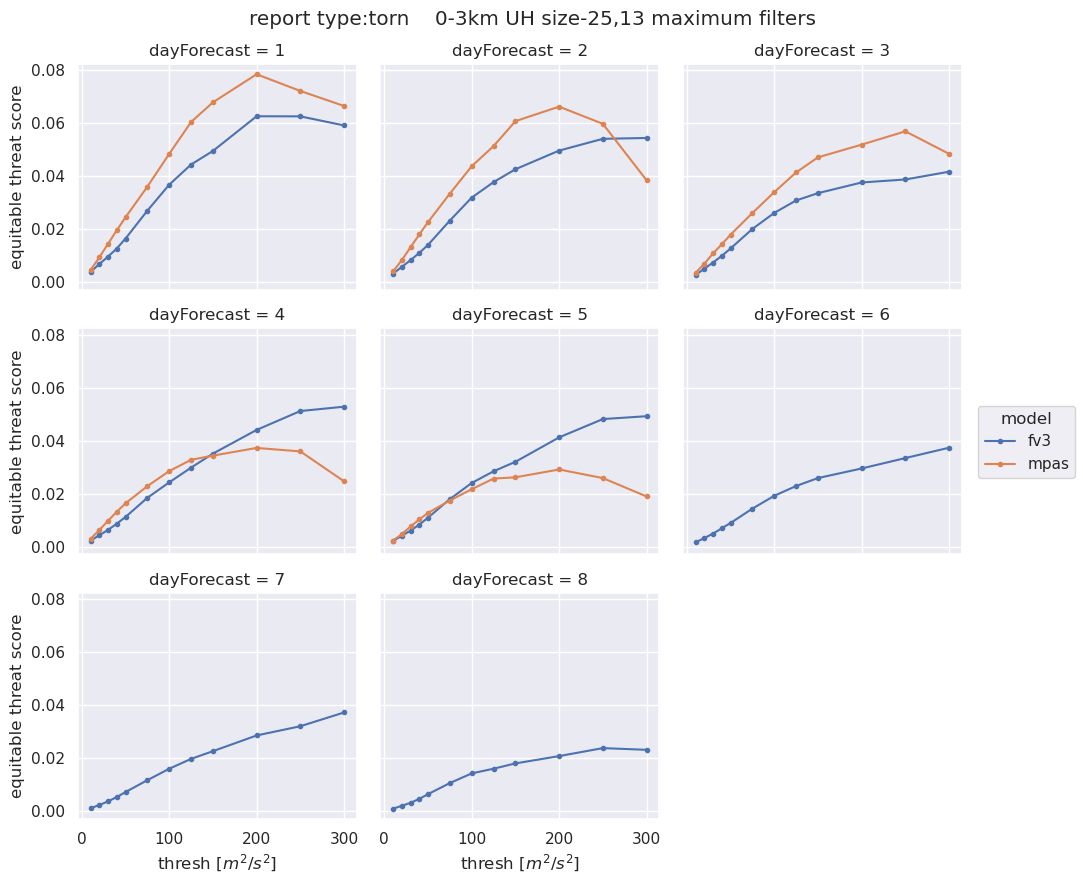

In [18]:
s = hmfn.hmfn
s = ets(s.sum(dim="valid_date"))
g = s.sel(variable=variable, rpt_type=rpt_type).plot(
    col="dayForecast", hue="model", col_wrap=3, marker="."
)
g.fig.suptitle(
    f"report type:{rpt_type}    {variable} size-{filter_size1},{filter_size2} maximum filters"
)
ofile = tmpdir / f"{s.attrs['short_name']}{sfx.rstrip('.nc')}.{sel['variable']}.png"
g.fig.subplots_adjust(top=0.92)
g.fig.savefig(ofile)
print(ofile)

In [19]:
ivalid_date = (
    (firstRun(2023) + pd.to_timedelta("4D") <= hmfn.valid_date)
    & (hmfn.valid_date < firstRun(2024))
) | (hmfn.valid_date >= (firstRun(2024) + pd.to_timedelta("4D")))

/glade/derecho/scratch/ahijevyc/tmp/bss.2023-2024.uh3.12.25,13.0-3km UH.png


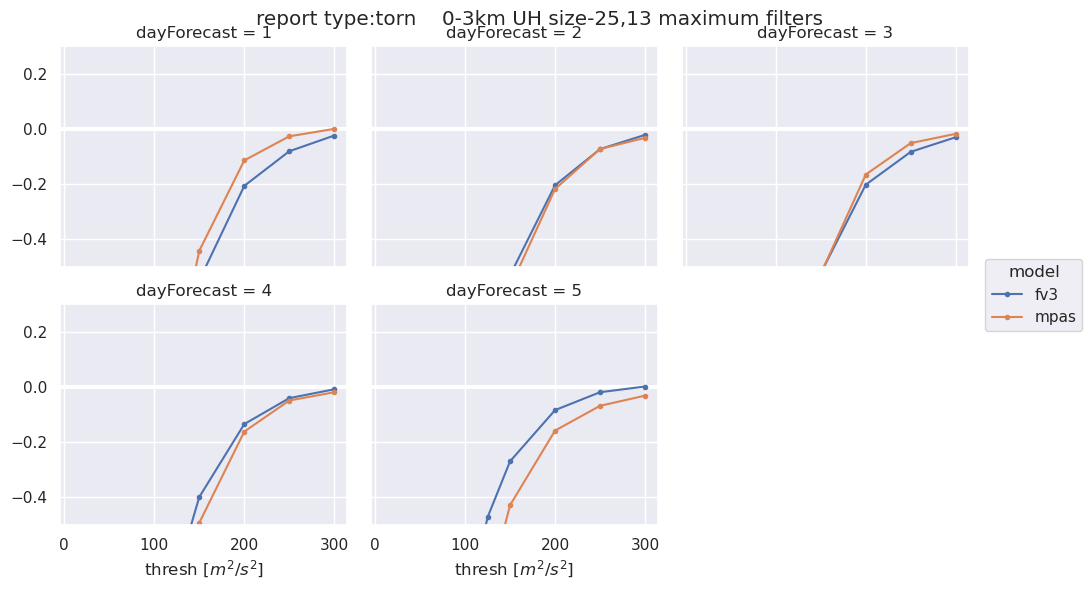

In [20]:
se = hmfn.fcstfcst + hmfn.obsobs - 2 * hmfn.fcstobs
se_ref = hmfnref.fcstfcst + hmfnref.obsobs - 2 * hmfnref.fcstobs
s = 1 - se.sel(valid_date=ivalid_date, dayForecast=slice(1, 5)).mean(
    dim="valid_date"
) / se_ref.sel(valid_date=ivalid_date).mean(dim="valid_date")
s.attrs["short_name"] = "bss"
g = s.sel(variable=variable, rpt_type=rpt_type).plot(
    col="dayForecast", hue="model", col_wrap=3, marker="."
)
g.fig.suptitle(
    f"report type:{rpt_type}    {variable} size-{filter_size1},{filter_size2} maximum filters"
)
[ax.set(ylim=(-0.5, 0.3)) for ax in g.axs.ravel()]
[ax.axhline(y=0, lw=3, color="white", zorder=1) for ax in g.axs.ravel()]

ofile = tmpdir / f"{s.attrs['short_name']}{sfx.rstrip('.nc')}.{sel['variable']}.png"
g.fig.subplots_adjust(top=0.92)
g.fig.savefig(ofile)
print(ofile)

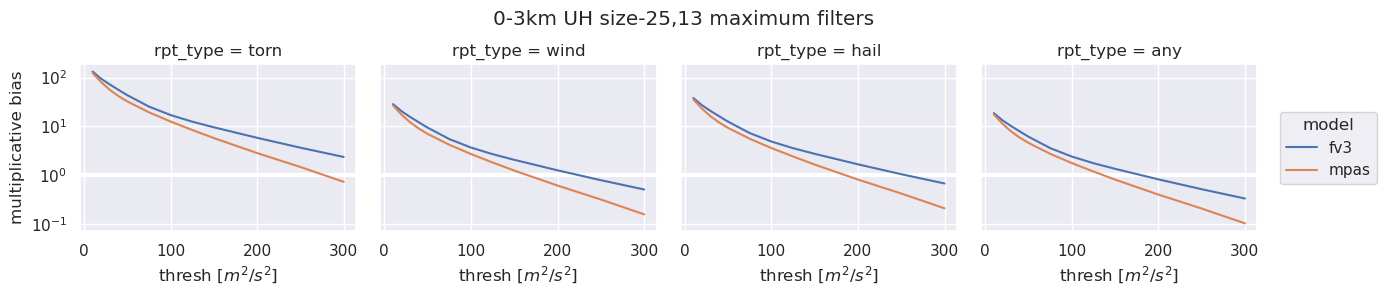

In [21]:
def noBiasLine(g, lw=3, color="w", zorder=1, **kwargs):
    [ax.axhline(y=1, lw=lw, color=color, zorder=zorder, **kwargs) for ax in g.axs.flatten()]


s = bias(
    hmfn.hmfn.sel(valid_date=ivalid_date, dayForecast=slice(1, 5))
    .sum(dim="valid_date")
    .sum(dim="dayForecast")
)
g = s.sel(variable=variable).plot(col="rpt_type", hue="model", yscale="log")
noBiasLine(g)
g.fig.suptitle(f"{variable} size-{filter_size1},{filter_size2} maximum filters")
g.fig.subplots_adjust(top=0.8)

/glade/derecho/scratch/ahijevyc/tmp/bss.byDay.byRptType.0-3km UH.png


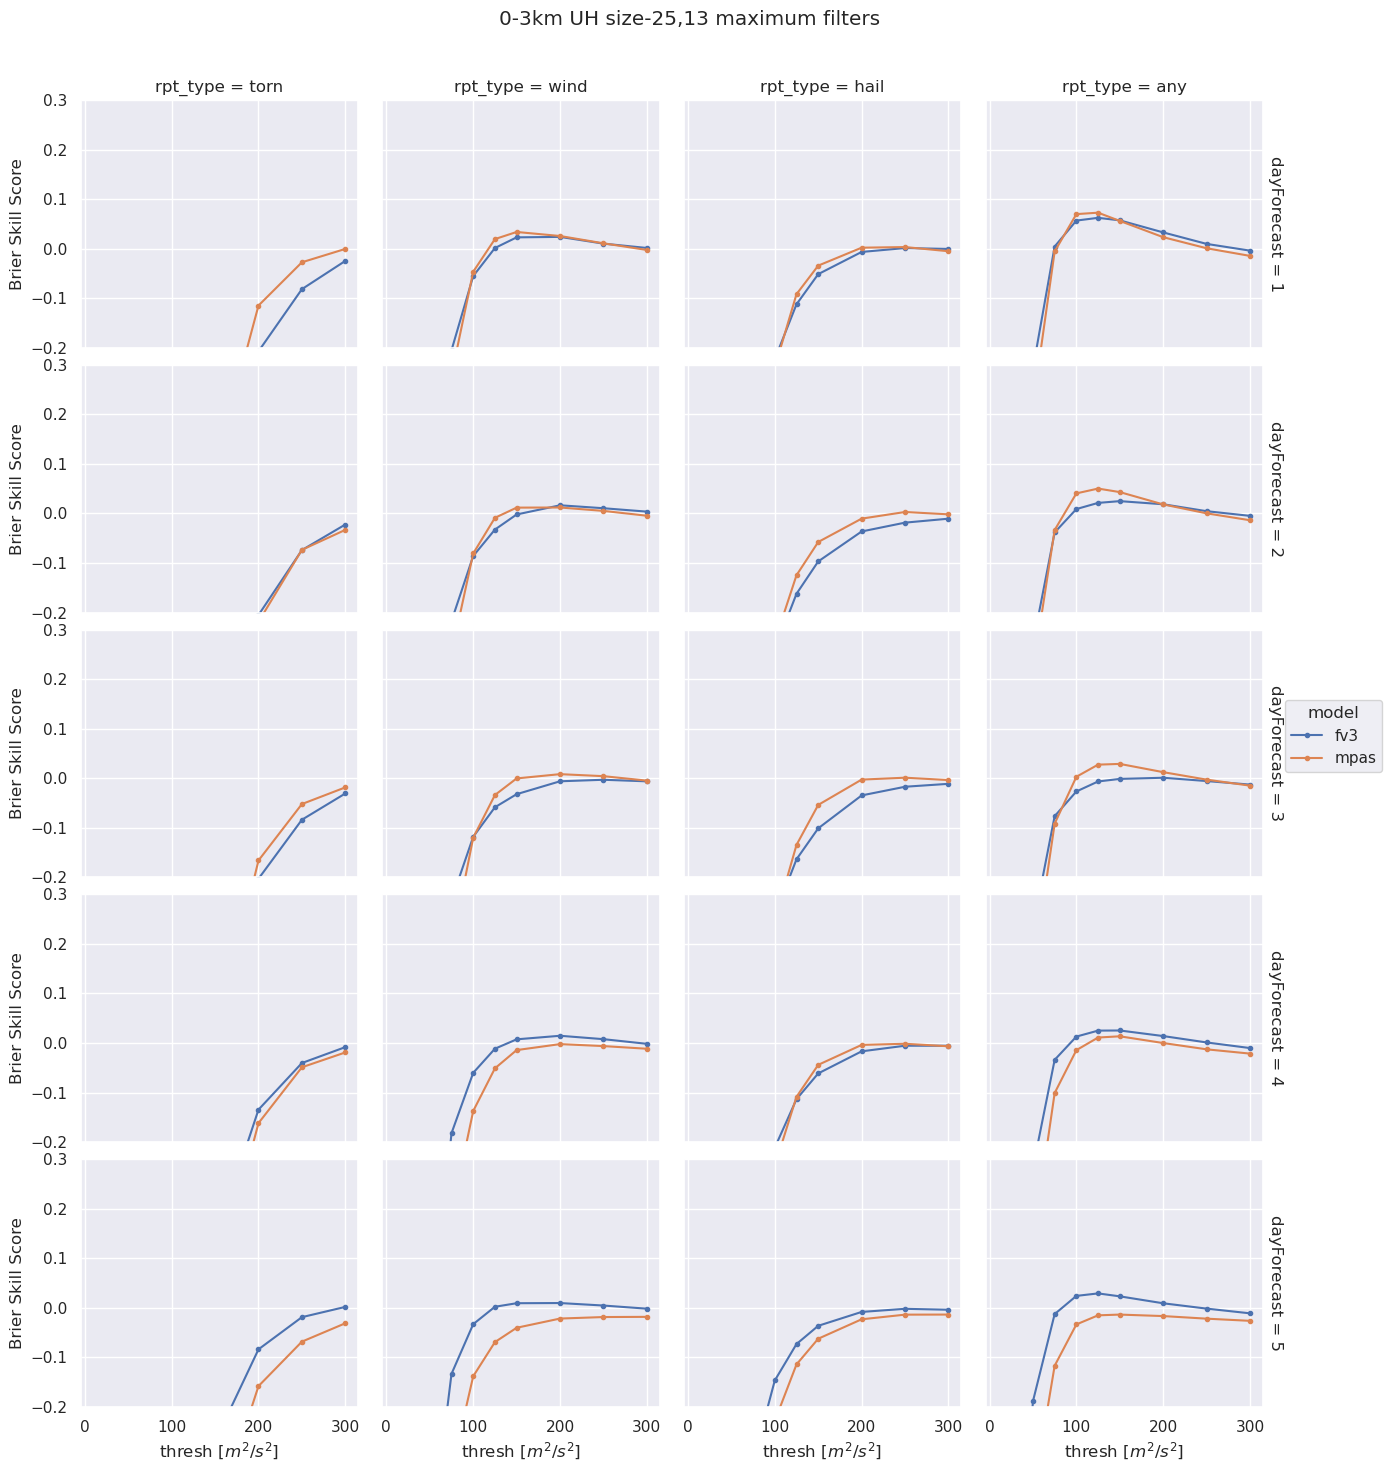

In [22]:
se = hmfn.fcstfcst + hmfn.obsobs - 2 * hmfn.fcstobs
se_ref = hmfnref.fcstfcst + hmfnref.obsobs - 2 * hmfnref.fcstobs
s = 1 - se.sel(valid_date=ivalid_date, dayForecast=slice(1, 5)).mean(
    dim="valid_date"
) / se_ref.sel(valid_date=ivalid_date).mean(dim="valid_date")
s.name = "Brier Skill Score"
s.attrs["short_name"] = "bss"
g = s.sel(variable=variable).plot(col="rpt_type", row="dayForecast", hue="model", marker=".")
[ax.set(ylim=(-0.2, 0.3)) for ax in g.axs.ravel()]
g.fig.suptitle(f"{variable} size-{filter_size1},{filter_size2} maximum filters")
g.fig.subplots_adjust(top=0.92)
ofile = tmpdir / f"bss.byDay.byRptType.{variable}.png"
g.fig.savefig(ofile)
print(ofile)

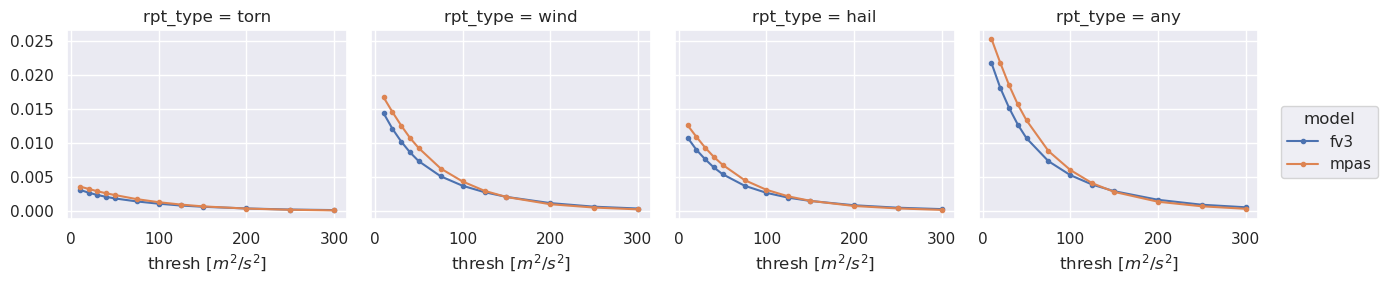

In [26]:
(hmfn.fcstobs / total(hmfn.hmfn)).mean(dim="valid_date").sel(dayForecast=1, variable=variable).plot(
    col="rpt_type", hue="model", marker="."
)

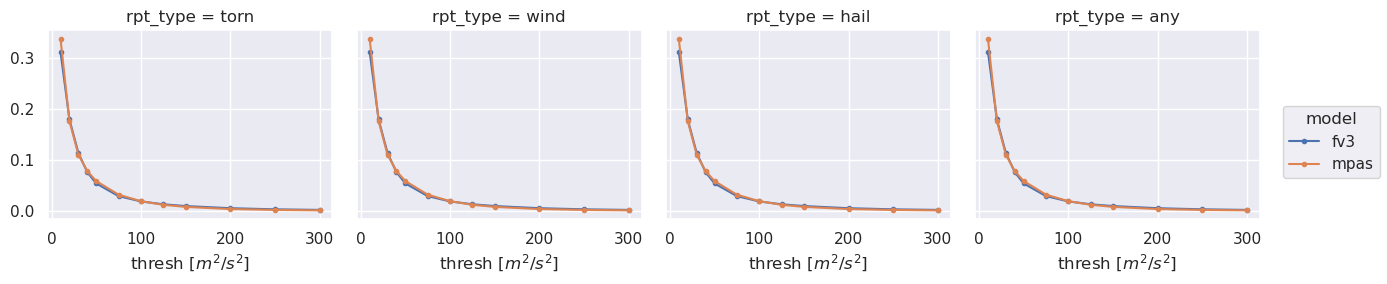

In [27]:
(hmfn.fcst / total(hmfn.hmfn)).sel(valid_date=ivalid_date).mean(dim="valid_date").sel(
    dayForecast=1, variable=variable
).plot(col="rpt_type", hue="model", marker=".")

In [28]:
def performance_diagram(color=None, label=None):
    """
    performace diagram
    xaxis = 1-far
    yaxis = prob of detection
    where far = fp / (tp+fp)
    """
    ax = plt.gca()
    bias_lines = [0.2, 0.5, 0.8, 1, 1.3, 2, 5]
    csi_lines = np.arange(0.1, 1.0, 0.1)
    alpha = 0.8
    color="0.8"
    lw = 1
    bias_pts = [
        [sr * b for sr in [0, 1.0]] for b in bias_lines
    ]  # compute pod values for each bias line
    csi_pts = np.array(
        [
            [csi / (csi - (csi / sr) + 1) for sr in np.arange(0.011, 1.01, 0.005)]
            for csi in csi_lines
        ]
    )  # compute pod values for each csi line
    csi_pts = np.ma.masked_array(csi_pts, mask=(csi_pts < 0.05))

    # add bias and CSI lines to performance diagram
    for r in bias_pts:
        ax.plot([0, 1], r, color=color, linestyle="dashed", lw=lw, alpha=alpha)
    for r in csi_pts:
        ax.plot(
            np.arange(0.01, 1.01, 0.005),
            r,
            color=color,
            alpha=alpha,
            linestyle="solid",
            linewidth=lw,
        )
    for x in [b for b in bias_lines if b <= 1]:
        ax.text(1.002, x, x, va="center", ha="left", fontsize="x-small", color="0.5")
    for x in [b for b in bias_lines if b > 1]:
        ax.text(1 / x, 1, x, va="baseline", ha="center", fontsize="xx-small", color="0.5")

    # axes limits, labels
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    return ax

In [29]:
x = 1 - far(hmfn.hmfn.sel(dayForecast=slice(1, 5)).sum(dim="valid_date"))
x.name = "1-far"
y = pod(hmfn.hmfn.sel(dayForecast=slice(1, 5)).sum(dim="valid_date"))
data = xarray.merge([x, y], compat="override")
data = data.sel(variable=variable).to_dataframe().drop(columns="count").reset_index(drop=False)
data

,dayForecast,thresh,rpt_type,model,variable,1-far,probability of detection
0,1,10,torn,fv3,0-3km UH,0.007758,0.967757
1,1,10,torn,mpas,0-3km UH,0.008456,0.983427
2,1,10,wind,fv3,0-3km UH,0.036297,0.961020
3,1,10,wind,mpas,0-3km UH,0.039625,0.978108
4,1,10,hail,fv3,0-3km UH,0.027726,0.953006
...,...,...,...,...,...,...,...
475,5,300,wind,mpas,0-3km UH,0.140772,0.025531
476,5,300,hail,fv3,0-3km UH,0.115256,0.087446
477,5,300,hail,mpas,0-3km UH,0.131616,0.031670
478,5,300,any,fv3,0-3km UH,0.254134,0.095001


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/seaborn/axisgrid.py:241: UserWarning: Legend does not support handles for Text instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/seaborn/axisgrid.py:241: UserWarning: Legend does not support handles for Text instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/seaborn/axisgrid.py:241: UserWarning: Legend does not support handles for Text instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/glade/u/apps/opt/conda/envs/npl-2

/glade/derecho/scratch/ahijevyc/tmp/performance_diagram.day1-5.0-3km UH.png


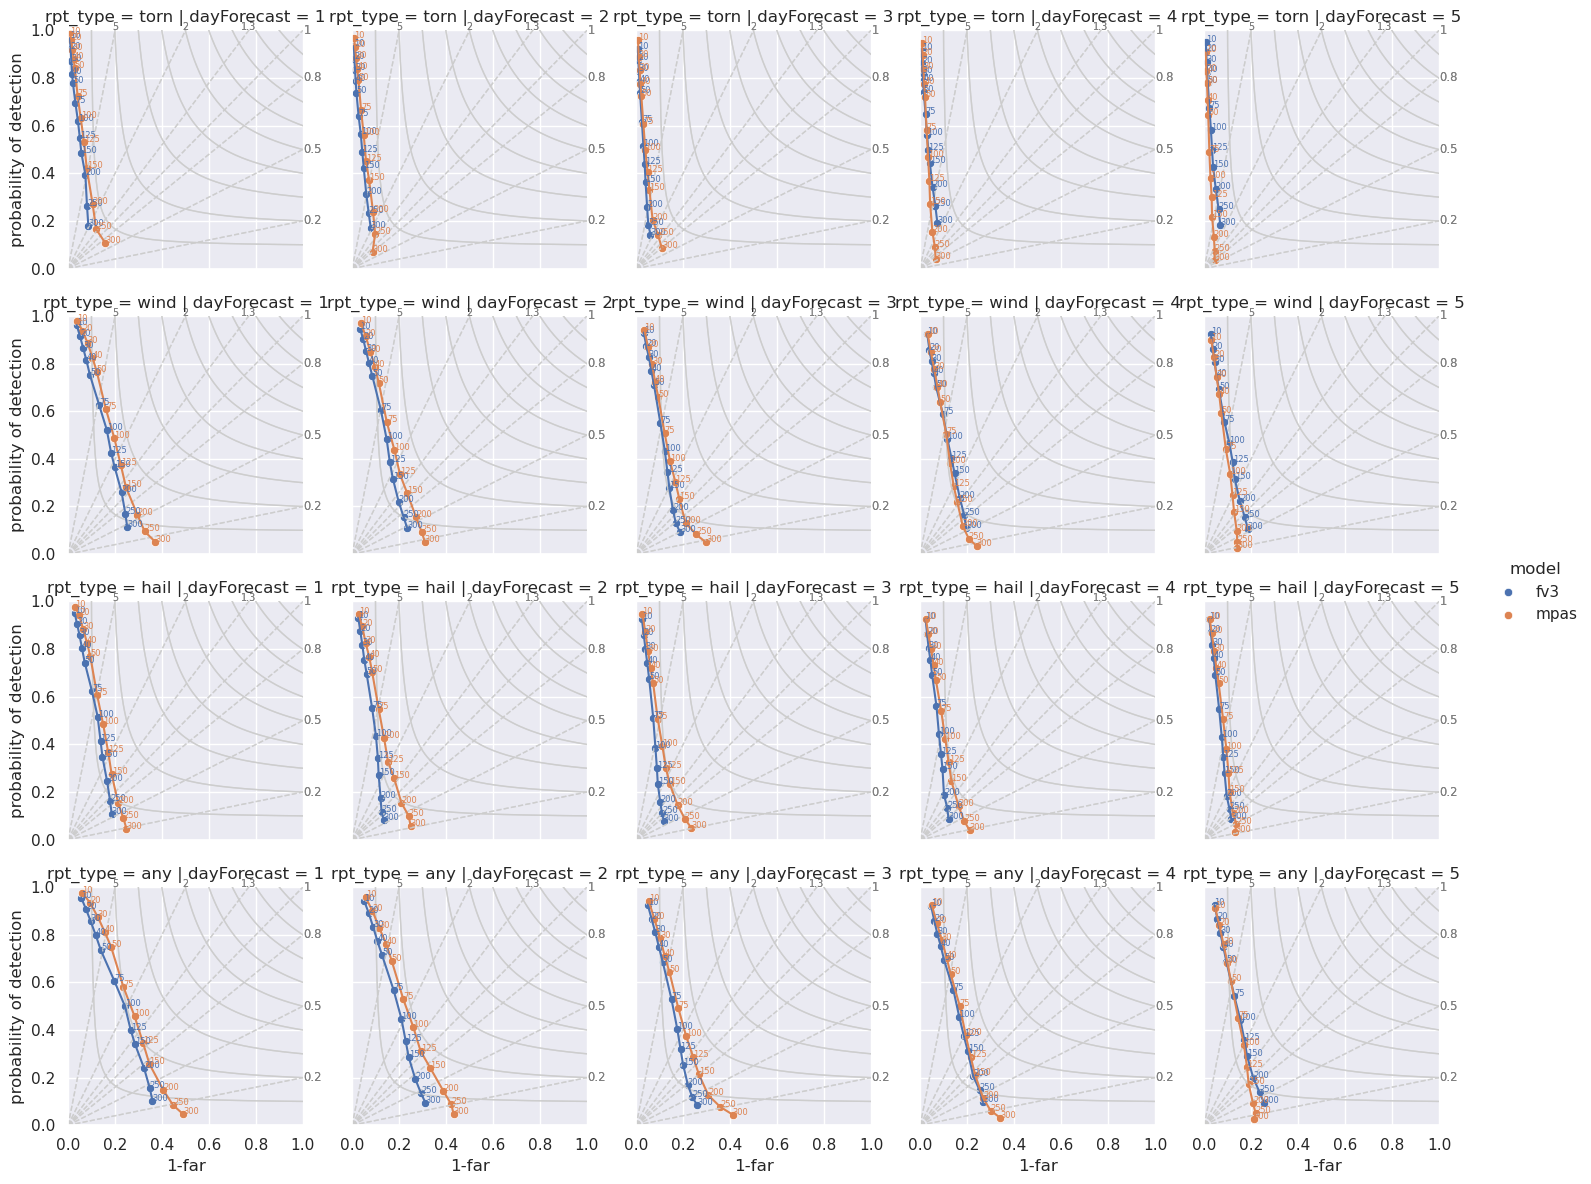

In [30]:
g = sns.FacetGrid(data, col="dayForecast", row="rpt_type", hue="model")
g.map(performance_diagram)
g.map(
    sns.lineplot, "1-far", "probability of detection", sort=False
)  # sort=False prevents jagged line
g.map(sns.scatterplot, "1-far", "probability of detection")

g.add_legend()


# Add text labels to each point
def add_text_labels(x, y, s, **kwargs):
    for i, v in x.items():
        plt.text(x[i], y[i], s[i], **kwargs)


g.map(add_text_labels, "1-far", "probability of detection", "thresh", fontsize=6)

ofile = tmpdir / f"performance_diagram.day1-5.{variable}.png"
g.fig.savefig(ofile)
print(ofile)

/glade/derecho/scratch/ahijevyc/tmp/ets.2023-2024.uh3.12.25,13.0-3km UH.day1-5avg.png


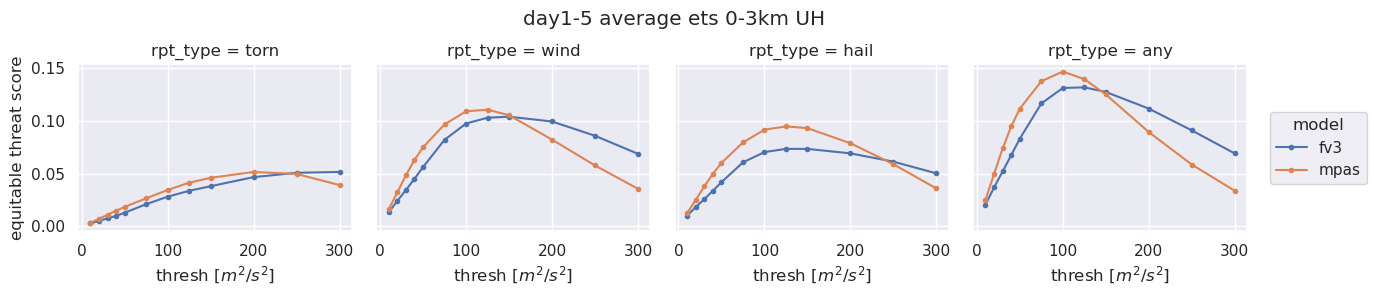

In [31]:
s = ets(hmfn.hmfn.sel(dayForecast=slice(1, 5)).mean(dim="dayForecast").mean(dim="valid_date"))
g = s.sel(variable=variable).plot(col="rpt_type", hue="model", marker=".")
ofile = tmpdir / f"{s.attrs['short_name']}{sfx.rstrip('.nc')}.{sel['variable']}.day1-5avg.png"
g.fig.suptitle(f"day1-5 average {s.attrs['short_name']} {variable}")
g.fig.subplots_adjust(top=0.8)
g.fig.savefig(ofile)
print(ofile)

## Calculate climatology
- Used in method above

In [32]:
O = hmfn.hmfn.sel(count="hits") + hmfn.hmfn.sel(count="misses")
climo = O / total(hmfn.hmfn)
# Could use first dayForecast cause it has more early dates, but use 5.
# use first of everything else because they are all the same
s = climo.sel(dayForecast=5).isel(thresh=0, variable=0, model=0).mean(dim="valid_date")
s

<xarray.DataArray (rpt_type: 4)> Size: 32B
array([0.00431742, 0.01998099, 0.01505983, 0.03056543])
Coordinates:
    dayForecast  int64 8B 5
    thresh       int64 8B 10
    variable     <U8 32B '0-1km UH'
  * rpt_type     (rpt_type) <U4 64B 'torn' 'wind' 'hail' 'any'
    model        <U4 16B 'fv3'

In [33]:
def otime(ds: xarray.Dataset):
    """get valid_date from filename, assign to coordinate"""

    # extract valid_date from file path
    # assign to its own coordinate
    # assume file path is like "/glade/derecho/scratch/ahijevyc/tmp/near_rpt.2024-05-23 00:00:00.nc"
    filename = Path(ds.encoding["source"])
    base, ext = os.path.splitext(filename)
    valid_date = pd.to_datetime(os.path.basename(base).replace("near_rpt.", ""))
    ds = ds.assign(valid_date=[valid_date])

    return ds


ifiles = list(datadir.glob("near_rpt.20??-??-?? ??:??:?[0-9].nc"))
print(len(ifiles))
climo = xarray.open_mfdataset(ifiles, preprocess=otime)
climo = climo.sel(valid_date=ivalid_date)
print(climo.valid_date.size)
any = climo.max(dim="rpt_type").assign_coords(rpt_type="any")
climo = xarray.concat([climo, any], dim="rpt_type")

# Keep where conus_mask is True; otherwise set to nan.
# nans will not be counted when the .mean() function is used below.
climo = climo.where(conus_mask)
climo = climo.mean(dim=["lon", "lat", "valid_date"]).compute()

assert np.allclose(climo.near_rpts.values, s.values), f"{climo.near_rpts.values} {s.values}"

80
72


In [34]:
bss = 1 - se.sel(valid_date=ivalid_date) / se_ref.sel(valid_date=ivalid_date)
s = bss.sel(dayForecast=5, variable=variable, rpt_type=rpt_type)
idx = (s.sel(model="mpas") - s.sel(model="fv3")).idxmax(dim="valid_date")
s.sel(valid_date=idx)

<xarray.DataArray (model: 2, thresh: 12)> Size: 192B
array([[-1.17471582e+04, -9.57466112e+03, -4.58260084e+03,
        -1.81967203e+03, -8.52805304e+02, -4.20799168e+02,
        -1.00928335e+02, -4.71151473e+01, -2.48630432e+01,
        -1.35815836e+01, -7.06154339e+01, -2.23708975e+01],
       [-8.85333473e+03, -5.02570842e+03, -2.01929191e+03,
        -1.04116975e+03, -4.21618398e+02, -2.67389460e+02,
        -4.08854864e+01, -1.56686853e+01, -6.22609728e+00,
         1.00000000e+00, -6.01616423e+01, -1.70441471e+01]])
Coordinates:
    dayForecast  int64 8B 5
  * thresh       (thresh) int64 96B 10 20 30 40 50 75 100 125 150 200 250 300
    variable     <U8 32B '0-3km UH'
    valid_date   (thresh) datetime64[ns] 96B 2023-05-01 ... 2024-05-15
  * model        (model) <U4 32B 'fv3' 'mpas'
    rpt_type     <U4 16B 'torn'

Text(0.5, 1.0, 'dayForecast = 5, thresh = [200] [$m^2/s^2$], variable = 0-3km UH, rpt_type = torn')

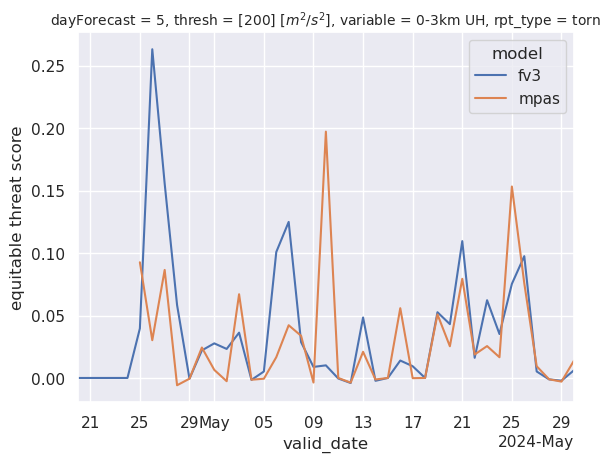

In [51]:
thresh = thresholds[thresholds == 200]
da = ets(
    hmfn.hmfn.sel(
        valid_date=ivalid_date, dayForecast=5, rpt_type="torn", thresh=thresh, variable=variable
    )
)
l = da.plot(
    hue="model",
)
l[0].axes.set_xlim((firstRun(2024), firstRun(2024) + pd.to_timedelta("40D")))
l[0].axes.set_title(da._title_for_slice(truncate=82), fontsize="small")

In [52]:
ets(
    hmfn.hmfn.sel(
        valid_date=ivalid_date, dayForecast=5, rpt_type="torn", thresh=thresh, variable=variable
    )
)._title_for_slice(truncate=100)

'dayForecast = 5, thresh = [200] [$m^2/s^2$], variable = 0-3km UH, rpt_type = torn'

In [53]:
valid_date = pd.to_datetime("20240525")
model = "mpas"

fcst = get_fcst(
    datadir, model, group, valid_date, filter_size=filter_size2, filter_type="maximum"
)
fcst = fcst.where(conus_mask)
example = "/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052100/post/mem_1/interp_mpas_3km_2024052100_mem1_f018.nc"
ds = xarray.open_dataset(example).squeeze()  # squeeze 1-element time dimension
fcst["lon"] = ds.longitude
fcst["lat"] = ds.latitude


# Define observations
obs = get_obs(datadir, valid_date)
obs["lon"] = ds.longitude
obs["lat"] = ds.latitude

/glade/derecho/scratch/ahijevyc/tmp/20240525.mpas.200.0-3km UH.png


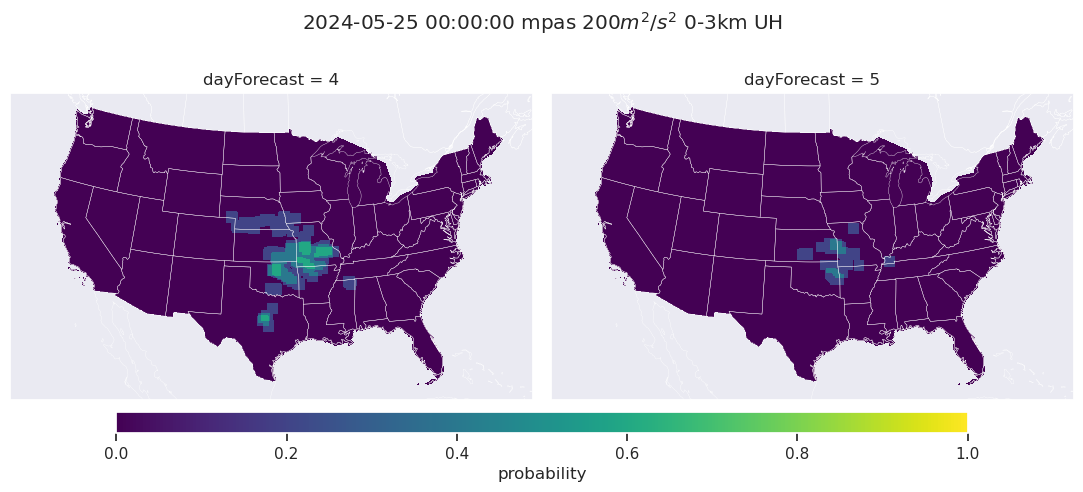

In [54]:
def dec_ax(ax, extent, **kwargs):
    ax.coastlines(color="white", **kwargs)
    ax.add_feature(cartopy.feature.STATES, edgecolor="white", **kwargs)
    ax.set_extent(extent)


fg = fcst.sel(variable=variable, thresh=thresh, dayForecast=[4, 5]).plot(
    col="dayForecast",
    col_wrap=2,
    transform=cartopy.crs.PlateCarree(),  # remember to provide this!
    subplot_kws={"projection": projection},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
    size=5,
    vmax=1,
)
fg.fig.suptitle(f"{valid_date} {model} {thresh.data[0]}{thresh.units} {variable}")
fg.map(lambda: dec_ax(plt.gca(), extent, lw=0.25))
fg.fig.subplots_adjust(bottom=0.2)
ofile = tmpdir / f"{valid_date.strftime('%Y%m%d')}.{model}.{thresh.data[0]}.{variable}.png"
fg.fig.savefig(ofile)
print(ofile)

/glade/derecho/scratch/ahijevyc/tmp/20240525.torn.png


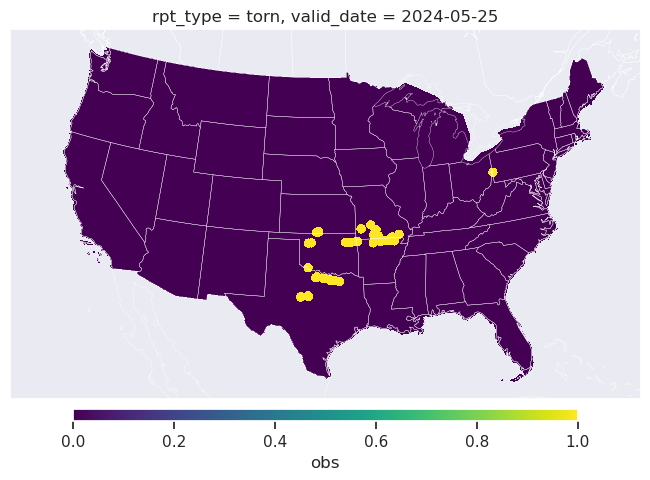

In [55]:
fg = obs.sel(rpt_type=rpt_type).plot(
    transform=cartopy.crs.PlateCarree(),  # remember to provide this!
    subplot_kws={"projection": projection},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40, "pad": 0.02},
    size=5,
)
dec_ax(fg.axes, extent, lw=0.25)
fg.figure.tight_layout()
ofile = tmpdir / f"{valid_date.strftime('%Y%m%d')}.{rpt_type}.png"
fg.figure.savefig(ofile)
print(ofile)

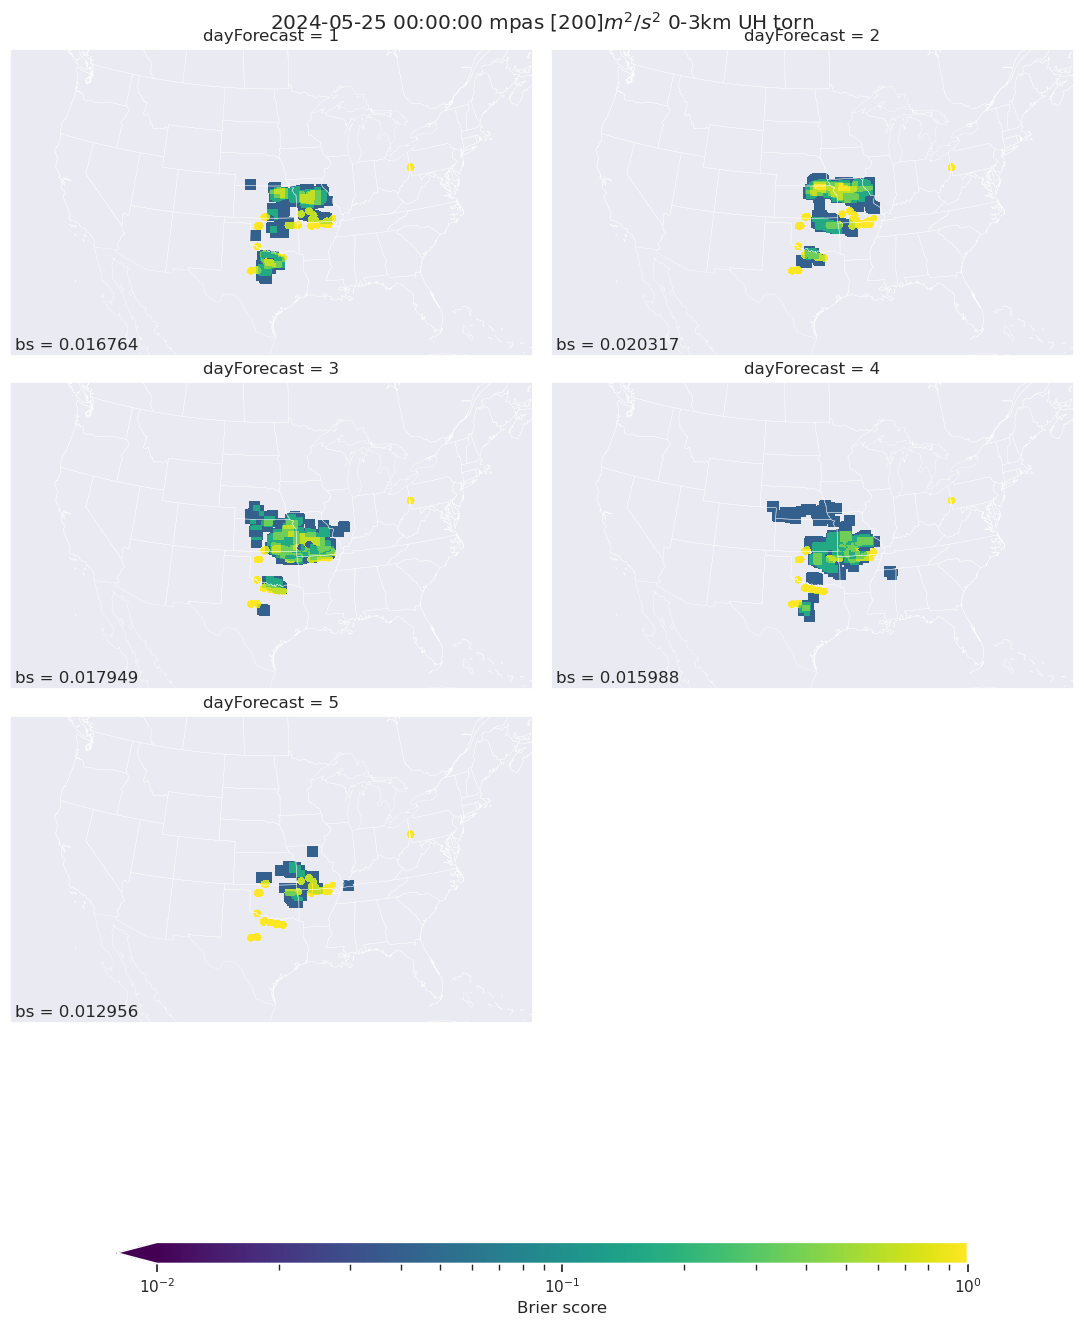

In [56]:
import matplotlib.colors as colors

bs = (fcst - obs) ** 2
bs.name = "Brier score"
# bs[:,:,:,0:330,:] = np.nan
fg = bs.sel(variable=variable, thresh=thresh, rpt_type=rpt_type).plot(
    col="dayForecast",
    col_wrap=2,
    transform=cartopy.crs.PlateCarree(),  # remember to provide this!
    subplot_kws={"projection": projection},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
    size=5,
    norm=colors.LogNorm(vmin=0.01, vmax=1),
)
fg.fig.suptitle(f"{valid_date} {model} {thresh.data}{thresh.units} {variable} {rpt_type}")
for ax, data in zip(fg.axs.flat, fg.data):
    ax.text(0.01, 0.02, f"bs = {data.mean().data:.6f}", transform=ax.transAxes)
    # extent2 = np.array(extent) + np.array([20, -10, 10, -10])
    dec_ax(ax, extent, lw=0.25)

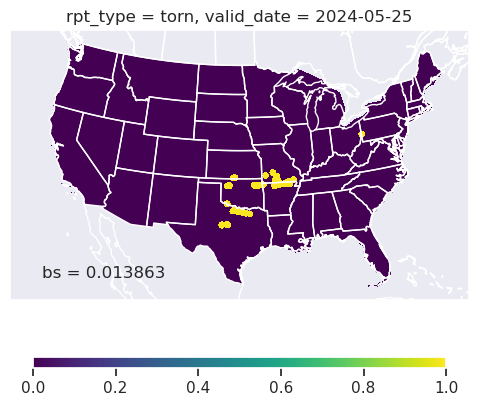

In [57]:
bsref = (climo.near_rpts - obs) ** 2
fg = bsref.sel(rpt_type=rpt_type).plot(
    transform=cartopy.crs.PlateCarree(),  # remember to provide this!
    subplot_kws={"projection": projection},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
    size=5,
    vmin=0,
    vmax=1,
)
fg.axes.text(-120, 24, f"bs = {fg.get_array().mean():.6f}", transform=cartopy.crs.PlateCarree())
dec_ax(fg.axes, extent)

In [58]:
(1 - bs.mean(dim=["lat", "lon"]) / bsref.mean(dim=["lat", "lon"])).sel(
    variable=variable, thresh=thresh, rpt_type=rpt_type
)

<xarray.DataArray (thresh: 1, dayForecast: 5)> Size: 40B
array([[-0.20924834, -0.46555036, -0.29473439, -0.15326034,  0.06542744]])
Coordinates:
  * dayForecast  (dayForecast) int64 40B 1 2 3 4 5
  * thresh       (thresh) int64 8B 200
    variable     <U8 32B '0-3km UH'
    valid_date   datetime64[ns] 8B 2024-05-25
    rpt_type     <U4 16B 'torn'

In [59]:
se = hmfn.fcstfcst + hmfn.obsobs - 2 * hmfn.fcstobs
se_ref = hmfnref.fcstfcst + hmfnref.obsobs - 2 * hmfnref.fcstobs

(1 - se / se_ref).sel(
    model=model, valid_date=valid_date, variable=variable, thresh=thresh, rpt_type=rpt_type
)

<xarray.DataArray (thresh: 1, dayForecast: 8)> Size: 64B
array([[-0.20864116, -0.4648145 , -0.29408429, -0.15268128,  0.0658967 ,
                nan,         nan,         nan]])
Coordinates:
  * dayForecast  (dayForecast) int64 64B 1 2 3 4 5 6 7 8
  * thresh       (thresh) int64 8B 200
    variable     <U8 32B '0-3km UH'
    valid_date   datetime64[ns] 8B 2024-05-25
    model        <U4 16B 'mpas'
    rpt_type     <U4 16B 'torn'